# NetworkX - beagle - Labelling
------------------

- ID Bad Processes in the Malicious Subgraph
- ID Bad Files + Bad Reg Keys in the Malicious Subgraph
- See if Bad Files + Bad Reg Keys show up in the ancestor chain elsewhere
- Add those processes to the Bad Processes List
- Try to solve the Lateral Movement Missing Edge...

# Preparation

In [1]:
import pandas as pd, numpy as np, networkx as nx
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from sklearn.linear_model.logistic import LogisticRegression
pd.options.display.max_columns = 500
pd.options.display.max_colwidth = 500

/home/jake/miniconda3/envs/py3msc/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.logistic module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df_zeek = pd.read_json("combined_zeek.log", lines = True)
df_zeek.replace('nan', np.nan, inplace=True)
print(type(df_zeek))
print(df_zeek.shape)
#print(df_zeek.EventID.value_counts())
df_zeek.head()

<class 'pandas.core.frame.DataFrame'>
(2140, 148)


,@stream,@system,@proc,ts,uid,id_orig_h,id_orig_p,id_resp_h,id_resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,orig_l2_addr,resp_l2_addr,rtt,named_pipe,endpoint,operation,trans_id,query,qclass,qclass_name,qtype,qtype_name,rcode,rcode_name,AA,TC,RD,RA,Z,answers,TTLs,rejected,analyzer,failure_reason,fuid,tx_hosts,rx_hosts,conn_uids,source,depth,analyzers,mime_type,filename,is_orig,seen_bytes,total_bytes,missing_bytes,overflow_bytes,timedout,md5,sha1,request_type,client,success,error_msg,till,forwardable,renewable,cipher,note,msg,sub,src,dst,p,actions,suppress_for,action,path,name,size,times_modified,times_accessed,times_created,times_changed,share_type,version,curve,server_name,resumed,established,cert_chain_fuids,client_cert_chain_fuids,subject,issuer,validation_status,resp_certificate_sha1,ja3,ja3s,notice,peer,addl,id,certificate_version,certificate_serial,certificate_subject,certificate_issuer,certificate_not_valid_before,certificate_not_valid_after,certificate_key_alg,certificate_sig_alg,certificate_key_type,certificate_key_length,certificate_exponent,basic_constraints_ca,extracted,extracted_cutoff,trans_depth,method,host,uri,user_agent,request_body_len,response_body_len,status_code,status_msg,tags,resp_fuids,resp_mime_types,client_header_names,orig_fuids,orig_mime_types,machine,compile_ts,os,subsystem,is_exe,is_64bit,uses_aslr,uses_dep,uses_code_integrity,uses_seh,has_import_table,has_export_table,has_cert_table,has_debug_data,section_names
0,conn,bobs.bigwheel.local,zeek,1.588205e+09,Cvf4XX17hSAgXDdGEd,10.0.1.6,54243.0,10.0.0.4,53.0,udp,dns,0.001528,39.0,55.0,SF,0.0,Dd,1.0,67.0,1.0,83.0,00:0d:3a:13:e3:69,12:34:56:78:9a:bc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,conn,bobs.bigwheel.local,zeek,1.588205e+09,CJ21Le4zsTUcyKKi98,10.0.1.6,56880.0,10.0.0.4,445.0,tcp,"gssapi,smb,krb",10.761077,4020.0,1681.0,RSTO,0.0,ShADdaR,12.0,1307.0,11.0,2133.0,00:0d:3a:13:e3:69,12:34:56:78:9a:bc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,conn,bobs.bigwheel.local,zeek,1.588205e+09,CnOP7t1eGGHf6LFfuk,10.0.1.6,65108.0,10.0.0.4,53.0,udp,dns,0.001599,36.0,104.0,SF,0.0,Dd,1.0,64.0,1.0,132.0,00:0d:3a:13:e3:69,12:34:56:78:9a:bc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,conn,bobs.bigwheel.local,zeek,1.588205e+09,CvxbPE3MuO7boUdSc8,10.0.1.6,138.0,10.0.1.255,138.0,udp,NaN,NaN,NaN,NaN,S0,0.0,D,1.0,229.0,0.0,0.0,00:0d:3a:13:e3:69,ff:ff:ff:ff:ff:ff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [3]:
df_label = pd.read_json('./df_labelled_coalesce.json', lines=True)
df_label['TP_Binary'] = df_label.TP_Label!='0'
df_label.replace('-', np.nan, inplace=True)
print(type(df_label))
print(df_label.shape)
print(df_label.EventID.value_counts())
df_label.head(1)

<class 'pandas.core.frame.DataFrame'>
(198760, 390)
12       61158
10       39286
7        20259
13       17542
4658     10973
         ...  
172          1
46           1
50103        1
306          1
41           1
Name: EventID, Length: 165, dtype: int64


,@timestamp,@version,Category,Channel,EventID,EventReceivedTime,EventTime,EventType,ExecutionProcessID,Hostname,IpAddress,IpPort,Keywords,LogonGuid,Message,Opcode,OpcodeValue,ProviderGuid,RecordNumber,ServiceName,ServiceSid,Severity,SeverityValue,SourceModuleName,SourceModuleType,SourceName,Status,TargetDomainName,TargetUserName,Task,ThreadID,TicketEncryptionType,TicketOptions,TransmittedServices,Version,host,port,tags,TP_Label,Action,ActivityID,CalloutKey,CalloutName,ChangeType,Conditions,FilterId,FilterKey,FilterName,FilterType,LayerId,LayerKey,LayerName,ProcessId,ProviderKey,ProviderName,UserName,UserSid,Weight,AccessList,AccessMask,AccessReason,HandleId,ObjectName,ObjectServer,ObjectType,PrivilegeList,ProcessName,ResourceAttributes,RestrictedSidCount,SubjectDomainName,SubjectLogonId,SubjectUserName,SubjectUserSid,TransactionId,ShareLocalPath,ShareName,RelativeTargetName,CommandLine,MandatoryLabel,NewProcessId,NewProcessName,ParentProcessName,TargetLogonId,TargetUserSid,TokenElevationType,Service,DisabledPrivilegeList,EnabledPrivilegeList,CallerProcessId,CallerProcessName,TargetSid,AuthenticationPackageName,ElevatedToken,ImpersonationLevel,KeyLength,LmPackageName,LogonProcessName,LogonType,RestrictedAdminMode,TargetLinkedLogonId,TargetOutboundDomainName,TargetOutboundUserName,VirtualAccount,WorkstationName,SourceHandleId,SourceProcessId,TargetHandleId,TargetProcessId,AccountName,AccountType,ContextInfo,Domain,Payload,UserID,NewThreadId,RuleName,SourceImage,SourceProcessGuid,StartAddress,StartFunction,StartModule,TargetImage,TargetProcessGuid,UtcTime,MessageNumber,MessageTotal,Path,ScriptBlockId,ScriptBlockText,AlgorithmName,KeyName,KeyType,Operation,ReturnCode,Archived,Hashes,Image,IsExecutable,ProcessGuid,TargetFilename,User,CreationUtcTime,Company,Description,FileVersion,ImageLoaded,OriginalFileName,Product,Signature,SignatureStatus,Signed,DestinationHostname,DestinationIp,DestinationIsIpv6,DestinationPort,DestinationPortName,Initiated,Protocol,SourceHostname,SourceIp,SourceIsIpv6,SourcePort,SourcePortName,NewSd,OldSd,PipeName,CurrentDirectory,IntegrityLevel,LogonId,ParentCommandLine,ParentImage,ParentProcessGuid,ParentProcessId,TerminalSessionId,CallTrace,GrantedAccess,SourceProcessGUID,SourceThreadId,TargetProcessGUID,Device,TargetObject,Details,Application,FilterRTID,LayerRTID,SourceAddress,DestAddress,DestPort,Direction,RemoteMachineID,RemoteUserID,BootMenuPolicy,NewValue,NewValueType,ObjectValueName,OldValue,OldValueType,OperationType,ProfileUsed,RuleId,QueryName,QueryResults,QueryStatus,PreviousCreationUtcTime,EventCountTotal,EventIdx,GroupMembership,param1,Properties,Hash,PreAuthType,ClientProcessId,CountOfCredentialsReturned,ProcessCreationTime,ReadOperation,TargetName,Type,CalloutId,CalloutType,CorruptionActionState,DeviceName,DriveName,Config,IsTestConfig,DirtyPages,HiveName,HiveNameLength,KeysUpdated,PackageName,Workstation,DeviceNameLength,DeviceTime,DeviceVersionMajor,DeviceVersionMinor,FinalStatus,UserData,ServiceAccount,ServiceFileName,ServiceStartType,ServiceType,param10,param11,param2,param3,param4,param5,param6,param7,param8,param9,SubLayerKey,SubLayerName,SubLayerType,Default SD String:,ClassId,ClassName,CompatibleIds,DeviceDescription,DeviceId,LocationInformation,VendorIds,TargetProcessName,SecurityPackageName,AdditionalInfo,AdditionalInfo2,ProviderType,RuleAttr,AdapterName,AdapterSuffixName,DnsServerList,ErrorCode,Ipaddress,Sent UpdateServer,TaskContentNew,TaskName,ActiveProfile,MiniportName,MiniportNameLen,GroupPolicyApplied,LogDroppedPacketsEnabled,LogSuccessfulConnectionsEnabled,MulticastFlowsEnabled,OperationMode,Profile,RemoteAdminEnabled,TargetInfo,TargetLogonGuid,TargetServerName,ClientCreationTime,TimeSource,ImagePath,StartType,ProfileChanged,BootType,LoadOptions,EntryCount,KeyFilePath,ProviderContextKey,ProviderContextName,ProviderContextType,DwordVal,InterfaceGuid,InterfaceName,NewProfile,OldProfile,InstanceId,MaxRunspaces,MinRunspaces,CurrentStratumNumber,TimeSourceRefId,ReasonForRejection,

In [4]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
#    In [9]: result = pd.concat([df1, df4], axis=1, sort=False)
df_label = df_label.append(df_zeek, ignore_index=True, sort=False)

In [4]:
df_label.shape

(198760, 390)

In [5]:
df_label.head(1)

,@timestamp,@version,Category,Channel,EventID,EventReceivedTime,EventTime,EventType,ExecutionProcessID,Hostname,IpAddress,IpPort,Keywords,LogonGuid,Message,Opcode,OpcodeValue,ProviderGuid,RecordNumber,ServiceName,ServiceSid,Severity,SeverityValue,SourceModuleName,SourceModuleType,SourceName,Status,TargetDomainName,TargetUserName,Task,ThreadID,TicketEncryptionType,TicketOptions,TransmittedServices,Version,host,port,tags,TP_Label,Action,ActivityID,CalloutKey,CalloutName,ChangeType,Conditions,FilterId,FilterKey,FilterName,FilterType,LayerId,LayerKey,LayerName,ProcessId,ProviderKey,ProviderName,UserName,UserSid,Weight,AccessList,AccessMask,AccessReason,HandleId,ObjectName,ObjectServer,ObjectType,PrivilegeList,ProcessName,ResourceAttributes,RestrictedSidCount,SubjectDomainName,SubjectLogonId,SubjectUserName,SubjectUserSid,TransactionId,ShareLocalPath,ShareName,RelativeTargetName,CommandLine,MandatoryLabel,NewProcessId,NewProcessName,ParentProcessName,TargetLogonId,TargetUserSid,TokenElevationType,Service,DisabledPrivilegeList,EnabledPrivilegeList,CallerProcessId,CallerProcessName,TargetSid,AuthenticationPackageName,ElevatedToken,ImpersonationLevel,KeyLength,LmPackageName,LogonProcessName,LogonType,RestrictedAdminMode,TargetLinkedLogonId,TargetOutboundDomainName,TargetOutboundUserName,VirtualAccount,WorkstationName,SourceHandleId,SourceProcessId,TargetHandleId,TargetProcessId,AccountName,AccountType,ContextInfo,Domain,Payload,UserID,NewThreadId,RuleName,SourceImage,SourceProcessGuid,StartAddress,StartFunction,StartModule,TargetImage,TargetProcessGuid,UtcTime,MessageNumber,MessageTotal,Path,ScriptBlockId,ScriptBlockText,AlgorithmName,KeyName,KeyType,Operation,ReturnCode,Archived,Hashes,Image,IsExecutable,ProcessGuid,TargetFilename,User,CreationUtcTime,Company,Description,FileVersion,ImageLoaded,OriginalFileName,Product,Signature,SignatureStatus,Signed,DestinationHostname,DestinationIp,DestinationIsIpv6,DestinationPort,DestinationPortName,Initiated,Protocol,SourceHostname,SourceIp,SourceIsIpv6,SourcePort,SourcePortName,NewSd,OldSd,PipeName,CurrentDirectory,IntegrityLevel,LogonId,ParentCommandLine,ParentImage,ParentProcessGuid,ParentProcessId,TerminalSessionId,CallTrace,GrantedAccess,SourceProcessGUID,SourceThreadId,TargetProcessGUID,Device,TargetObject,Details,Application,FilterRTID,LayerRTID,SourceAddress,DestAddress,DestPort,Direction,RemoteMachineID,RemoteUserID,BootMenuPolicy,NewValue,NewValueType,ObjectValueName,OldValue,OldValueType,OperationType,ProfileUsed,RuleId,QueryName,QueryResults,QueryStatus,PreviousCreationUtcTime,EventCountTotal,EventIdx,GroupMembership,param1,Properties,Hash,PreAuthType,ClientProcessId,CountOfCredentialsReturned,ProcessCreationTime,ReadOperation,TargetName,Type,CalloutId,CalloutType,CorruptionActionState,DeviceName,DriveName,Config,IsTestConfig,DirtyPages,HiveName,HiveNameLength,KeysUpdated,PackageName,Workstation,DeviceNameLength,DeviceTime,DeviceVersionMajor,DeviceVersionMinor,FinalStatus,UserData,ServiceAccount,ServiceFileName,ServiceStartType,ServiceType,param10,param11,param2,param3,param4,param5,param6,param7,param8,param9,SubLayerKey,SubLayerName,SubLayerType,Default SD String:,ClassId,ClassName,CompatibleIds,DeviceDescription,DeviceId,LocationInformation,VendorIds,TargetProcessName,SecurityPackageName,AdditionalInfo,AdditionalInfo2,ProviderType,RuleAttr,AdapterName,AdapterSuffixName,DnsServerList,ErrorCode,Ipaddress,Sent UpdateServer,TaskContentNew,TaskName,ActiveProfile,MiniportName,MiniportNameLen,GroupPolicyApplied,LogDroppedPacketsEnabled,LogSuccessfulConnectionsEnabled,MulticastFlowsEnabled,OperationMode,Profile,RemoteAdminEnabled,TargetInfo,TargetLogonGuid,TargetServerName,ClientCreationTime,TimeSource,ImagePath,StartType,ProfileChanged,BootType,LoadOptions,EntryCount,KeyFilePath,ProviderContextKey,ProviderContextName,ProviderContextType,DwordVal,InterfaceGuid,InterfaceName,NewProfile,OldProfile,InstanceId,MaxRunspaces,MinRunspaces,CurrentStratumNumber,TimeSourceRefId,ReasonForRejection,

In [6]:
df_label.tail(1)

,@timestamp,@version,Category,Channel,EventID,EventReceivedTime,EventTime,EventType,ExecutionProcessID,Hostname,IpAddress,IpPort,Keywords,LogonGuid,Message,Opcode,OpcodeValue,ProviderGuid,RecordNumber,ServiceName,ServiceSid,Severity,SeverityValue,SourceModuleName,SourceModuleType,SourceName,Status,TargetDomainName,TargetUserName,Task,ThreadID,TicketEncryptionType,TicketOptions,TransmittedServices,Version,host,port,tags,TP_Label,Action,ActivityID,CalloutKey,CalloutName,ChangeType,Conditions,FilterId,FilterKey,FilterName,FilterType,LayerId,LayerKey,LayerName,ProcessId,ProviderKey,ProviderName,UserName,UserSid,Weight,AccessList,AccessMask,AccessReason,HandleId,ObjectName,ObjectServer,ObjectType,PrivilegeList,ProcessName,ResourceAttributes,RestrictedSidCount,SubjectDomainName,SubjectLogonId,SubjectUserName,SubjectUserSid,TransactionId,ShareLocalPath,ShareName,RelativeTargetName,CommandLine,MandatoryLabel,NewProcessId,NewProcessName,ParentProcessName,TargetLogonId,TargetUserSid,TokenElevationType,Service,DisabledPrivilegeList,EnabledPrivilegeList,CallerProcessId,CallerProcessName,TargetSid,AuthenticationPackageName,ElevatedToken,ImpersonationLevel,KeyLength,LmPackageName,LogonProcessName,LogonType,RestrictedAdminMode,TargetLinkedLogonId,TargetOutboundDomainName,TargetOutboundUserName,VirtualAccount,WorkstationName,SourceHandleId,SourceProcessId,TargetHandleId,TargetProcessId,AccountName,AccountType,ContextInfo,Domain,Payload,UserID,NewThreadId,RuleName,SourceImage,SourceProcessGuid,StartAddress,StartFunction,StartModule,TargetImage,TargetProcessGuid,UtcTime,MessageNumber,MessageTotal,Path,ScriptBlockId,ScriptBlockText,AlgorithmName,KeyName,KeyType,Operation,ReturnCode,Archived,Hashes,Image,IsExecutable,ProcessGuid,TargetFilename,User,CreationUtcTime,Company,Description,FileVersion,ImageLoaded,OriginalFileName,Product,Signature,SignatureStatus,Signed,DestinationHostname,DestinationIp,DestinationIsIpv6,DestinationPort,DestinationPortName,Initiated,Protocol,SourceHostname,SourceIp,SourceIsIpv6,SourcePort,SourcePortName,NewSd,OldSd,PipeName,CurrentDirectory,IntegrityLevel,LogonId,ParentCommandLine,ParentImage,ParentProcessGuid,ParentProcessId,TerminalSessionId,CallTrace,GrantedAccess,SourceProcessGUID,SourceThreadId,TargetProcessGUID,Device,TargetObject,Details,Application,FilterRTID,LayerRTID,SourceAddress,DestAddress,DestPort,Direction,RemoteMachineID,RemoteUserID,BootMenuPolicy,NewValue,NewValueType,ObjectValueName,OldValue,OldValueType,OperationType,ProfileUsed,RuleId,QueryName,QueryResults,QueryStatus,PreviousCreationUtcTime,EventCountTotal,EventIdx,GroupMembership,param1,Properties,Hash,PreAuthType,ClientProcessId,CountOfCredentialsReturned,ProcessCreationTime,ReadOperation,TargetName,Type,CalloutId,CalloutType,CorruptionActionState,DeviceName,DriveName,Config,IsTestConfig,DirtyPages,HiveName,HiveNameLength,KeysUpdated,PackageName,Workstation,DeviceNameLength,DeviceTime,DeviceVersionMajor,DeviceVersionMinor,FinalStatus,UserData,ServiceAccount,ServiceFileName,ServiceStartType,ServiceType,param10,param11,param2,param3,param4,param5,param6,param7,param8,param9,SubLayerKey,SubLayerName,SubLayerType,Default SD String:,ClassId,ClassName,CompatibleIds,DeviceDescription,DeviceId,LocationInformation,VendorIds,TargetProcessName,SecurityPackageName,AdditionalInfo,AdditionalInfo2,ProviderType,RuleAttr,AdapterName,AdapterSuffixName,DnsServerList,ErrorCode,Ipaddress,Sent UpdateServer,TaskContentNew,TaskName,ActiveProfile,MiniportName,MiniportNameLen,GroupPolicyApplied,LogDroppedPacketsEnabled,LogSuccessfulConnectionsEnabled,MulticastFlowsEnabled,OperationMode,Profile,RemoteAdminEnabled,TargetInfo,TargetLogonGuid,TargetServerName,ClientCreationTime,TimeSource,ImagePath,StartType,ProfileChanged,BootType,LoadOptions,EntryCount,KeyFilePath,ProviderContextKey,ProviderContextName,ProviderContextType,DwordVal,InterfaceGuid,InterfaceName,NewProfile,OldProfile,InstanceId,MaxRunspaces,MinRunspaces,CurrentStratumNumber,TimeSourceRefId,ReasonForRejection,

## Normalize Timestamp, IP/Port Columns
------------------

In [7]:
df_label['time_stamp'] = df_label['@timestamp'].apply(lambda x: (pd.Timestamp(x)))

In [9]:
df_label['time_stamp'] = df_label['time_stamp'].fillna(df_label['ts'].apply(lambda x: (pd.to_datetime(x, unit='s', utc=True))))

In [8]:
# Transform Host Data - Similar Data to Single Columns
df_label['Destination_IP'] = df_label['DestinationIp']
df_label['Destination_IP'] = df_label['Destination_IP'].fillna(df_label['DestAddress'])
df_label['Source_IP'] = df_label['IpAddress']
df_label['Source_IP'] = df_label['Source_IP'].fillna(df_label['SourceIp'])
df_label['Source_IP'] = df_label['Source_IP'].fillna(df_label['SourceAddress'])
df_label['Source_Port'] = df_label['IpPort']
df_label['Source_Port'] = df_label['Source_Port'].fillna(df_label['SourcePort'])
df_label['Destination_Port'] = df_label['DestinationPort']
df_label['Destination_Port'] = df_label['Destination_Port'].fillna(df_label['DestPort'])

In [11]:
# Transform Network Data - Similar Data to Single Columns
df_label['Source_IP'] = df_label['Source_IP'].fillna(df_label['id_orig_h'])
df_label['Source_Port'] = df_label['Source_Port'].fillna(df_label['id_orig_p'])
df_label['Destination_IP'] = df_label['Destination_IP'].fillna(df_label['id_resp_h'])
df_label['Destination_Port'] = df_label['Destination_Port'].fillna(df_label['id_resp_p'])

## Beagle Column Formatting

In [9]:
# Sysmon Transformer
df_label['EventData_ParentImage'] = df_label['ParentImage'].astype(object)
df_label['EventData_ParentProcessId'] = df_label['ParentProcessId']
df_label['EventData_ParentProcessGuid'] = df_label['ParentProcessGuid']
df_label['EventData_Image'] = df_label['Image'].astype(object)
df_label['EventData_CommandLine'] = df_label['CommandLine'].astype(object)
df_label['EventData_Hashes'] = df_label['Hashes'].astype(object)

df_label['Computer'] = df_label['Hostname'].astype(object)
df_label['EventData_User'] = df_label['User'].astype(object)
df_label['EventData_UtcTime'] = df_label['UtcTime']

df_label['EventData_ProcessGuid'] = df_label['ProcessGuid']
df_label['EventData_ProcessId'] = df_label['ProcessId']

df_label['EventData_DestinationIp'] = df_label['DestinationIp']
df_label['EventData_DestinationPort'] = df_label['DestinationPort']
df_label['EventData_Protocol'] = df_label['Protocol']
df_label['EventData_TargetFilename'] = df_label['TargetFilename']

df_label['EventData_TargetObject'] = df_label['TargetObject']
df_label['EventData_EventType'] = df_label['EventType']
#df_label['EventData_Details'] = df_label['ProcessId']


In [ ]:
# EVTX Transformer
#event_id = int(event["eventid_qualifiers"])
df_label['eventid_qualifiers'] = df_label['EventID']

#parent_pid = int(event["data_name_processid"], 16)
df_label['data_name_processid'] = df_label['ProcessId']

#child_pid = int(event["data_name_newprocessid"], 16)
df_label['data_name_newprocessid'] = df_label['NewProcessId']

#proc_name, proc_path = split_path(event["data_name_newprocessname"])
df_label['data_name_newprocessname'] = df_label['NewProcessName']

#child = Process(
#    host=event["computer"],
df_label['computer'] = df_label['Hostname'].astype(object)
#    process_id=child_pid,
#    user=event["data_name_subjectusername"],
df_label['data_name_subjectusername'] = df_label['SubjectUserName']

#    process_image=proc_name,
#    process_image_path=proc_path,
#    command_line=event.get("data_name_commandline"),
df_label['data_name_commandline'] = df_label['CommandLine']
#)
#parent.launched[child].append(timestamp=event["timecreated_systemtime"])
df_label['timecreated_systemtime'] = df_label['EventTime']

## Manual Recurse Ancestor Chain Functions

In [23]:
def eval_ancestor_chain(G, starting_guid):
    for (p, d) in G.nodes(data=True):
        if 'process_guid' in d['properties'].keys():
            if starting_guid in d['properties']['process_guid']:
                selected_node = p
                
    #ancestors = nx.ancestors(G, selected_node)
    malicious_ancestors = [selected_node]
    for i in nx.ancestors(G, selected_node):
        if(G.node[i]['_node_type'] == 'Process'):
            print("==========================================")
            print("Node Data:")
            print("==========================================")
            print(G.node[i])
            print("==========================================")
            answer = None
            while answer not in ("yes", "no"):
                answer = input("Malicious? Enter yes or no: ")
                if answer == "yes":
                    # Do this.
                    malicious_ancestors.append(i)
                elif answer == "no":
                    # Do that.
                    return malicious_ancestors
                else:
                    print("Please enter yes or no.")
    return malicious_ancestors

def determine_malicious_root_proc(G, starting_guid):
    malicious_ancestors = eval_ancestor_chain(G, starting_guid)
    print("")
    print("##########################################")
    print("Confirm this as the senior malicious node?")
    print("##########################################")
    print("Node Data:")
    print("==========================================")
    print(G.node[malicious_ancestors[-1]])
    print("==========================================")
    print("Edge Out Data:")
    print("==========================================")
    for i in G.out_edges(malicious_ancestors[-1], data=True):
        if i[2]['type'] == 'Launched':
            print(i[2]['type'])
            print(G.node[i[1]])
            print("==========================================")
    answer = None
    while answer not in ("yes", "no"):
        answer = input("Malicious? Enter yes or no: ")
        if answer == "yes":
            # Do this.
            return malicious_ancestors[-1]
        elif answer == "no":
            # Do that.
            print("Re-run the eval_ancestor chain")
            malicious_root_ancestor = determine_malicious_root_proc(G, starting_guid)
            return malicious_root_ancestor
        else:
            print("Please enter yes or no.")
            
def get_ancestor_descendant_graph(G, malicious_root_ancestor):
    print(malicious_root_ancestor)

    descendants = nx.descendants(G, malicious_root_ancestor) #Returns all nodes reachable from source in G.
    print(len(descendants))

    ancestors = nx.ancestors(G, malicious_root_ancestor)
    print(len(ancestors))

    suspected_malicious = list(ancestors) + list(descendants)
    suspected_malicious.append(malicious_root_ancestor)
    print(len(suspected_malicious))

    H = G.subgraph(suspected_malicious)
    return H, malicious_root_ancestor, ancestors, descendants

def print_ancestor_descendant_graph(H, malicious_root_ancestor, ancestors, descendants):
    from matplotlib.pyplot import figure
    # Why are there orphaned nodes? I forgot to add the OG node. Fixed.
    # https://networkx.github.io/documentation/networkx-1.9/examples/drawing/labels_and_colors.html
    #fig = plt.Figure()
    figure(figsize=(15, 12))
    pos=nx.kamada_kawai_layout(H) # positions for all nodes

    # nodes
    nx.draw_networkx_nodes(H,pos,
                       nodelist=list(ancestors),
                       node_color='r',
                       #node_size=500,
                       label='ancestors',
                   alpha=0.8)
    nx.draw_networkx_nodes(H,pos,
                       nodelist=list(descendants),
                       node_color='b',
                       #node_size=500,
                       label='descendants',
                   alpha=0.8)
    nx.draw_networkx_nodes(H,pos,
                       nodelist=[malicious_root_ancestor],
                       node_color='g',
                       #node_size=500,
                       label='starting-point',
                   alpha=0.8)

    # edges
    nx.draw_networkx_edges(H,pos,width=1.0,alpha=0.5)

    #plt.legend()
    plt.legend(loc='upper left')
    #fig.update_layout(legend=dict(x=-.1, y=1.2))
    plt.axis('off')
    print("Saving as: ancestor_descendants_" + str(malicious_root_ancestor) + ".png")
    plt.savefig("ancestor_descendants_" + str(malicious_root_ancestor) + ".png") # save as png
    plt.show() # display
    
def get_ancestor_descendant_types(H):
    file_nodes = []
    for (p, d) in H.nodes(data=True):
        if d['_node_type']=='File':
            file_nodes.append(p)
    len(file_nodes)

    proc_nodes = []
    for (p, d) in H.nodes(data=True):
        if d['_node_type']=='Process':
            proc_nodes.append(p)
    len(proc_nodes)

    ip_nodes = []
    for (p, d) in H.nodes(data=True):
        if d['_node_type']=='IP Address':
            ip_nodes.append(p)
    len(ip_nodes)
    
    return file_nodes, proc_nodes, ip_nodes

def print_ancestor_descendant_type_graph(H, malicious_root_ancestor, file_nodes, proc_nodes, ip_nodes):
    # Why are there orphaned nodes? I forgot to add the OG node. Fixed.
    # https://networkx.github.io/documentation/networkx-1.9/examples/drawing/labels_and_colors.html
    #fig = plt.Figure()
    figure(figsize=(15, 12))
    pos=nx.kamada_kawai_layout(H) # positions for all nodes

    # nodes
    nx.draw_networkx_nodes(H,pos,
                           nodelist=file_nodes,
                           node_color='r',
                           #node_size=500,
                           label='file_nodes',
                       alpha=0.8)
    nx.draw_networkx_nodes(H,pos,
                           nodelist=proc_nodes,
                           node_color='b',
                           #node_size=500,
                           label='proc_nodes',
                       alpha=0.8)
    nx.draw_networkx_nodes(H,pos,
                           nodelist=ip_nodes,
                           node_color='g',
                           #node_size=500,
                           label='ip_nodes',
                       alpha=0.8)

    # edges
    nx.draw_networkx_edges(H,pos,width=1.0,alpha=0.5)

    #plt.legend()
    plt.legend(loc='upper left')
    #fig.update_layout(legend=dict(x=-.1, y=1.2))
    plt.axis('off')
    print("Saving as: ancestor_descendants_nodeType_" + str(malicious_root_ancestor) + ".png")
    plt.savefig("ancestor_descendants_nodeType_" + str(malicious_root_ancestor) + ".png") # save as png
    plt.show() # display
    
def analyze_graph_vs_label_proc(H, proc_nodes):
    graph_bad_guids = []
    for i in proc_nodes:
        graph_bad_guids.append(H.node[i]['properties']['process_guid'])
    print(len(graph_bad_guids))
    #print(graph_bad_guids)
    
    label_bad_guids = df_label.loc[(df_label['TP_Binary'] == True) & (df_label.ProcessGuid.notnull())]['ProcessGuid'].unique()
    pd_all_guids = df_label.loc[(df_label.ProcessGuid.notnull()) & (df_label.CommandLine.notnull())][['ProcessGuid', 'Hostname', 'TP_Binary', 'CommandLine']]
    pd_all_guids['orig_label'] = False
    pd_all_guids['orig_label'].loc[pd_all_guids.ProcessGuid.isin(label_bad_guids)] = True

    pd_all_guids = pd_all_guids.drop(columns=['TP_Binary']).drop_duplicates()
    pd_all_guids['graph_label'] = False
    pd_all_guids['graph_label'].loc[pd_all_guids.ProcessGuid.isin(graph_bad_guids)] = True

    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
        display(pd_all_guids[['ProcessGuid', 'Hostname', 'orig_label', 'graph_label', 'CommandLine']].loc[((pd_all_guids.orig_label==True) | (pd_all_guids.graph_label==True))].sort_values(by=['orig_label', 'graph_label'], ascending=False))
        
def manual_recurse_pipeline(G, starting_point):
    malicious_root_ancestor = determine_malicious_root_proc(G, starting_point)
    print(malicious_root_ancestor)
    
    H, malicious_root_ancestor, ancestors, descendants = get_ancestor_descendant_graph(G, malicious_root_ancestor)
    
    print_ancestor_descendant_graph(H, malicious_root_ancestor, ancestors, descendants)
    
    file_nodes, proc_nodes, ip_nodes = get_ancestor_descendant_types(H)
    
    print_ancestor_descendant_type_graph(H, malicious_root_ancestor, file_nodes, proc_nodes, ip_nodes)
    
    analyze_graph_vs_label_proc(H, proc_nodes)
    
    return H, malicious_root_ancestor, ancestors, descendants, file_nodes, proc_nodes, ip_nodes


## Cluster Manual Recurse Functions

In [11]:
def new_eval_ancestor_chain(G, starting_guid):
    for (p, d) in G.nodes(data=True):
        if 'process_guid' in d['properties'].keys():
            if starting_guid in d['properties']['process_guid']:
                selected_node = p
                
    #ancestors = nx.ancestors(G, selected_node)
    malicious_ancestors = [selected_node]
    print("##########################################")
    print("Conduct Ancestor Chain Evaluation")
    print("##########################################")
    print("")
    for i in list([selected_node] + list(nx.ancestors(G, selected_node))):
        if(G.node[i]['_node_type'] == 'Process'):
            print("==========================================")
            print("Node " + str(i) + " Data:")
            print("==========================================")
            print(G.node[i])
            print("==========================================")
            H, malicious_root_ancestor, ancestors, descendants = get_ancestor_descendant_graph(G, i)
            df = get_graph_dataframe(G)
            
            print("==========================================")
            print("Node " + str(i) + " Ancestor/Descendant Chain:")
            print("==========================================")
            current_node_eval(df, malicious_root_ancestor, ancestors, descendants)
            
            print("==========================================")
            print("Node " + str(i) + " Community Analysis:")
            print("==========================================")
            clusterings = ['Greedy_Mod', 'BestPartition', 'label_prop']
            for j in clusterings:
                print(j)
                get_community_analysis(df, j)
            
            answer = None
            while answer not in ("yes", "no"):
                answer = input("Malicious? Enter yes or no: ")
                if answer == "yes":
                    # Do this.
                    malicious_ancestors.append(i)
                elif answer == "no":
                    # Do that.
                    return malicious_ancestors
                else:
                    print("Please enter yes or no.")
    return malicious_ancestors

def get_ancestor_descendant_graph(G, malicious_root_ancestor):
    print(malicious_root_ancestor)

    descendants = nx.descendants(G, malicious_root_ancestor) #Returns all nodes reachable from source in G.
    print(len(descendants))

    ancestors = nx.ancestors(G, malicious_root_ancestor)
    print(len(ancestors))

    suspected_malicious = list(ancestors) + list(descendants)
    suspected_malicious.append(malicious_root_ancestor)
    print(len(suspected_malicious))

    H = G.subgraph(suspected_malicious)
    return H, malicious_root_ancestor, ancestors, descendants

def get_graph_dataframe(G):
    df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
    df = pd.concat([df.drop(['properties'], axis=1), df['properties'].apply(pd.Series)], axis=1)
    df = df.reset_index().rename(columns={"index" : "NodeID"})
    # Don't know why but the best partition label isn't set in the node attributes..
    #     it's working now. must have been an execution order issue.
    #df['BestPartition'] = df['NodeID'].apply(lambda x: (best_partition[x]))
    return df

def current_node_eval(df, malicious_root_ancestor, ancestors, descendants):
    df['Chain_Loc'] = np.nan
    df['Chain_Loc'].loc[df.NodeID.isin(list(ancestors))] = '1_Ancestor' #[['_display', 'DegreeCentrality']]
    df['Chain_Loc'].loc[df.NodeID.isin([malicious_root_ancestor])] = '2_Root' #[['_display', 'DegreeCentrality']]
    df['Chain_Loc'].loc[df.NodeID.isin(list(descendants))] = '3_Descendant' #[['_display', 'DegreeCentrality']]
    df['Chain_Loc_Int'] = np.nan
    df['Chain_Loc_Int'].loc[df.NodeID.isin([malicious_root_ancestor])] = 0 #[['_display', 'DegreeCentrality']]
    counter = 1
    for i in ancestors:
        df['Chain_Loc_Int'].loc[df['NodeID'] == i] = counter #[['_display', 'DegreeCentrality']]
        counter += 1
    columnList = ['_display', '_node_type', 'Chain_Loc', 'Chain_Loc_Int', 'BestPartition', 'Greedy_Mod', 'label_prop', 'betweenness', 'DegreeCentrality', 'ClusterCoef', 'AveNeighDegree']
    display(df.loc[(((df['Chain_Loc']=='1_Ancestor') & (df['_node_type']=='Process'))| (df['Chain_Loc']=='2_Root') | ((df['Chain_Loc']=='3_Descendant') & (df['_node_type']=='Process')))].sort_values(by=['Chain_Loc_Int'], ascending=True)[columnList])
    
def get_community_analysis(df, clustering):
    df['Chain_Loc'] = df.Chain_Loc.fillna(False)
    #df.groupby('Chain_Loc', 'Greedy_Mod').count()
    Greedy_Mod_In = dict(df.loc[df.Chain_Loc!=False][clustering].value_counts())
    Greedy_Mod_Out = dict(df.loc[df.Chain_Loc==False][clustering].value_counts())
    Greedy_Mod_All = dict(df[clustering].value_counts())

    Greedy_Mod_In_Proc = dict(df.loc[(df.Chain_Loc!=False) & (df._node_type=='Process')][clustering].value_counts())
    Greedy_Mod_In_Proc

    Greedy_Mod_Out_Proc = dict(df.loc[(df.Chain_Loc==False) & (df._node_type=='Process')][clustering].value_counts())
    Greedy_Mod_All_Proc = dict(df.loc[(df._node_type=='Process')][clustering].value_counts())

    combo_dict = {}
    for i, j in Greedy_Mod_In.items():
        combo_dict[i] = {
            'in_all' : j,
            'out_all' : 0,
            'all_all' : Greedy_Mod_All[i],
            'in_proc' : 0,
            'out_proc' : 0,
            'all_proc' : 0,
        }
        if i in Greedy_Mod_Out:
            combo_dict[i]['out_all'] = Greedy_Mod_Out[i]
        combo_dict[i]['All_Type_Percent_Malicious'] = (combo_dict[i]['in_all'] / combo_dict[i]['all_all'])

        if i in Greedy_Mod_Out_Proc:
            combo_dict[i]['out_proc'] = Greedy_Mod_Out_Proc[i]

        if i in Greedy_Mod_In_Proc:
            combo_dict[i]['in_proc'] = Greedy_Mod_In_Proc[i]

        if i in Greedy_Mod_All_Proc:
            combo_dict[i]['all_proc'] = Greedy_Mod_All_Proc[i]
            combo_dict[i]['Proc_Type_Percent_Malicious'] = (combo_dict[i]['in_proc'] / combo_dict[i]['all_proc'])

    display(pd.DataFrame(combo_dict).transpose().sort_values('Proc_Type_Percent_Malicious', ascending=False))

# Beagle Graph Construction

In [27]:
from beagle.backends import NetworkX
from beagle.transformers import SysmonTransformer

import os
import json
from typing import Dict, Generator, List

from beagle.datasources.base_datasource import DataSource
from beagle.transformers import GenericTransformer
from beagle.transformers.sysmon_transformer import SysmonTransformer

class JSONData(DataSource):
    """A generic data source which returns events one by one
    """

    name = "JSON Data"
    transformers = [SysmonTransformer]
    category = "Generic Data"

    def __init__(self, events: List[Dict]) -> None:
        self._events = events

    def events(self) -> Generator[dict, None, None]:
        for event in self._events:
            yield event

    def metadata(self) -> dict:
        return {}
    
# 4688 events just throw things off with no added information.
NX = NetworkX.from_datasources(
    datasources=[
#        WinJSONData(df_label.loc[(df_label['EventID']==4688)].to_dict('records')),
        JSONData(df_label.loc[(df_label['EventID']==1)].to_dict('records')),
        JSONData(df_label.loc[(df_label['EventID']==3)].to_dict('records')),
        JSONData(df_label.loc[(df_label['EventID']==11)].to_dict('records')),
#        JSONData(df_label.loc[(df_label['EventID']==13)].to_dict('records')),
#        JSONData(df_label.loc[(df_label['EventID']==14)].head(100).to_dict('records')),

    ]
)
G = NX.graph()
#G
graph_json = NetworkX.graph_to_json(G)

from networkx.readwrite import json_graph
G = json_graph.node_link_graph(graph_json)
G = nx.convert_node_labels_to_integers(G, first_label=0, ordering='default', label_attribute='Orig_Node_ID')

2020-07-09T08:53:16 | beagle.transformers.sysmon_transformer.__init__:15 | INFO | Created Sysmon Transformer.
2020-07-09T08:53:16 | beagle.transformers.base_transformer._consumer_thread:143 | WARNING | Error when parsing event, recieved exception 'float' object has no attribute 'split'
2020-07-09T08:53:16 | beagle.transformers.base_transformer._consumer_thread:143 | WARNING | Error when parsing event, recieved exception 'float' object has no attribute 'split'
2020-07-09T08:53:16 | beagle.transformers.base_transformer._consumer_thread:143 | WARNING | Error when parsing event, recieved exception 'float' object has no attribute 'split'
2020-07-09T08:53:16 | beagle.transformers.base_transformer._consumer_thread:143 | WARNING | Error when parsing event, recieved exception 'float' object has no attribute 'split'
2020-07-09T08:53:16 | beagle.transformers.base_transformer.run:111 | INFO | Finished processing of events, created 1784 nodes.
2020-07-09T08:53:16 | beagle.transformers.base_transfor

# Scranton Malicious

Node Data:
{'properties': {'process_guid': '{47ab858c-dac4-5eac-f202-000000000400}', 'host': 'SCRANTON.dmevals.local', 'process_id': 4440, 'user': nan, 'process_image': 'Explorer.EXE', 'process_image_path': 'C:\\windows', 'command_line': None, 'hashes': {}, 'process_path': 'C:\\windows\\Explorer.EXE'}, '_node_type': 'Process', '_node_class': 'SysMonProc', '_display': 'Explorer.EXE', '_color': '#FF0000', 'Orig_Node_ID': 7673672582009509699}


Malicious? Enter yes or no:  no



##########################################
Confirm this as the senior malicious node?
##########################################
Node Data:
{'properties': {'process_guid': '{47ab858c-e13c-5eac-a903-000000000400}', 'host': 'SCRANTON.dmevals.local', 'process_id': 8524, 'user': nan, 'process_image': 'â€®cod.3aka3.scr', 'process_image_path': 'C:\\ProgramData\\victim', 'command_line': '"C:\\ProgramData\\victim\\â€®cod.3aka3.scr" /S', 'hashes': {'sha1': '4B7FA56A4E85F88B98D11A6E018698AE3FBA5E62', 'md5': '9D1C5EF38E6073661C74660B3A71A76E', 'sha256': '0DF38A55D940F498478EB03683C94D4584236E100125B526A67650BA54DF4AE4', 'imphash': 'F00447512A354E59D39D2818AABA4A17'}, 'process_path': 'C:\\ProgramData\\victim\\â€®cod.3aka3.scr'}, '_node_type': 'Process', '_node_class': 'SysMonProc', '_display': 'â€®cod.3aka3.scr', '_color': '#FF0000', 'Orig_Node_ID': -7553225382156665427}
Edge Out Data:
Launched
{'properties': {'process_guid': '{47ab858c-e188-5eac-af03-000000000400}', 'host': 'SCRANTON.dmevals.loc

Malicious? Enter yes or no:  yes


1365
1365
489
4
494


/home/jake/miniconda3/envs/py3msc/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/jake/miniconda3/envs/py3msc/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


Saving as: ancestor_descendants_1365.png


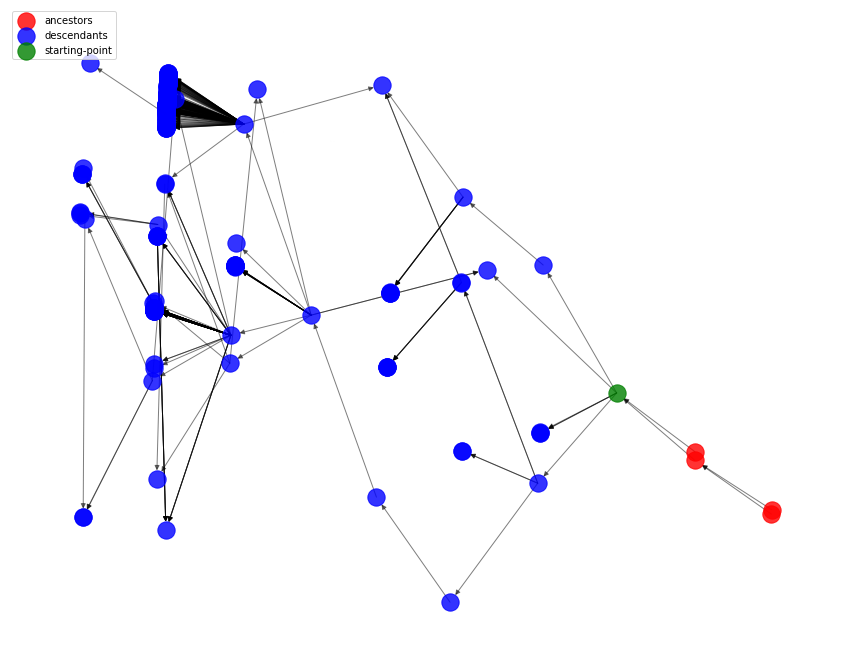

Saving as: ancestor_descendants_nodeType_1365.png


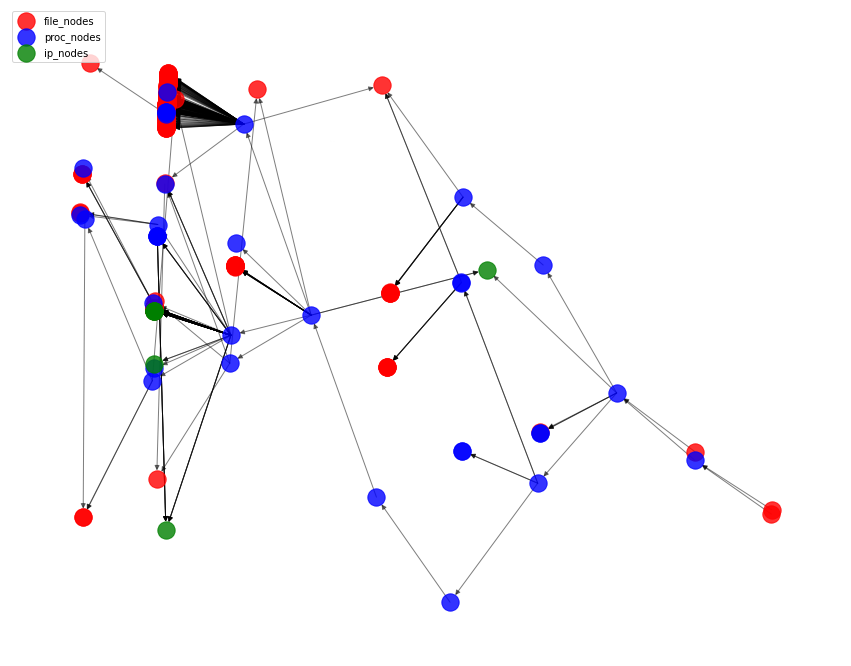

35


/home/jake/miniconda3/envs/py3msc/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,ProcessGuid,Hostname,orig_label,graph_label,CommandLine
8974,{47ab858c-e342-5eac-d703-000000000400},SCRANTON.dmevals.local,True,True,"""C:\Program Files\SysinternalsSuite\accesschk.exe"""
14768,{47ab858c-e23d-5eac-c603-000000000400},SCRANTON.dmevals.local,True,True,powershell.exe
39393,{47ab858c-e2f2-5eac-d203-000000000400},SCRANTON.dmevals.local,True,True,"""C:\Program Files\SysinternalsSuite\sdelete64.exe"" /accepteula C:\Users\pbeesly\AppData\Roaming\Draft.Zip"
60037,{47ab858c-e1f8-5eac-bc03-000000000400},SCRANTON.dmevals.local,True,True,powershell
68686,{47ab858c-e2ac-5eac-cb03-000000000400},SCRANTON.dmevals.local,True,True,"""C:\Program Files\SysinternalsSuite\sdelete64.exe"" /accepteula C:\programdata\victim\???cod.3aka3.scr"
72642,{47ab858c-e18b-5eac-b103-000000000400},SCRANTON.dmevals.local,True,True,powershell
96356,{47ab858c-e1e4-5eac-b803-000000000400},SCRANTON.dmevals.local,True,True,"""PowerShell.exe"" -noni -noexit -ep bypass -window hidden -c ""sal a New-Object;Add-Type -AssemblyName 'System.Drawing'; $g=a System.Drawing.Bitmap('C:\Users\pbeesly\Downloads\monkey.png');$o=a Byte[] 4480;for($i=0; $i -le 6; $i++){foreach($x in(0..639)){$p=$g.GetPixel($x,$i);$o[$i*640+$x]=([math]::Floor(($p.B-band15)*16)-bor($p.G-band15))}};$g.Dispose();IEX([System.Text.Encoding]::ASCII.GetString($o[0..3932]))"""
113037,{47ab858c-e188-5eac-b003-000000000400},SCRANTON.dmevals.local,True,True,"""C:\windows\system32\cmd.exe"""
120642,{47ab858c-e144-5eac-ab03-000000000400},SCRANTON.dmevals.local,True,True,"""C:\windows\system32\cmd.exe"""
130522,{47ab858c-e305-5eac-d303-000000000400},SCRANTON.dmevals.local,True,True,"""C:\Program Files\SysinternalsSuite\sdelete64.exe"" /accepteula C:\Users\pbeesly\Downloads\SysinternalsSuite.zip"


In [28]:
from matplotlib.pyplot import figure
H, malicious_root_ancestor, ancestors, descendants, file_nodes, proc_nodes, ip_nodes = manual_recurse_pipeline(G, '{47ab858c-e13c-5eac-a903-000000000400}')

In [ ]:
def get_ancestor_descendant_types(H):
    file_nodes = []
    for (p, d) in H.nodes(data=True):
        if d['_node_type']=='File':
            file_nodes.append(p)
    len(file_nodes)

    proc_nodes = []
    for (p, d) in H.nodes(data=True):
        if d['_node_type']=='Process':
            proc_nodes.append(p)
    len(proc_nodes)

    ip_nodes = []
    for (p, d) in H.nodes(data=True):
        if d['_node_type']=='IP Address':
            ip_nodes.append(p)
    len(ip_nodes)
    
    return file_nodes, proc_nodes, ip_nodes

In [33]:
df = get_graph_dataframe(G)
df.head(1)

,NodeID,_node_type,_node_class,_display,_color,Orig_Node_ID,process_guid,host,process_id,user,process_image,process_image_path,command_line,hashes,process_path,file_path,file_name,full_path,extension,ip_address,mac
0,0,Process,SysMonProc,svchost.exe,#FF0000,-3370743496798502505,{47ab858c-cadc-5eac-2200-000000000400},SCRANTON.dmevals.local,1448.0,None,svchost.exe,C:\Windows\System32,None,{},C:\Windows\System32\svchost.exe,NaN,NaN,NaN,NaN,NaN,NaN


# Bad Processes

In [62]:
df[df['NodeID'].str.contains("hostui.lnk", na=False)]

,NodeID,_node_type,_node_class,_display,_color,Orig_Node_ID,process_guid,host,process_id,user,process_image,process_image_path,command_line,hashes,process_path,file_path,file_name,full_path,extension,ip_address,mac


In [57]:
print("")
print("##########################################")
print("Confirm this as the senior malicious node?")
print("##########################################")
print("Node Data:")
print("==========================================")
print(G.node[659])
print("==========================================")
print("Edge In Data:")
print("==========================================")
for i in G.in_edges(659, data=True):
    print(i)
    print(G.node[i[0]])


##########################################
Confirm this as the senior malicious node?
##########################################
Node Data:
{'properties': {'host': None, 'file_path': 'C:\\ProgramData\\Microsoft\\Windows\\Start Menu\\Programs\\StartUp', 'file_name': 'hostui.lnk', 'full_path': 'C:\\ProgramData\\Microsoft\\Windows\\Start Menu\\Programs\\StartUp\\hostui.lnk', 'extension': None, 'hashes': {}}, '_node_type': 'File', '_node_class': 'File', '_display': 'hostui.lnk', '_color': '#3CB371', 'Orig_Node_ID': -8898675217237747392}
Edge Out Data:
(279, 659, {'id': 1390, 'type': 'Accessed', 'properties': {'data': {'timestamp': '2020-05-02 03:04:23.681'}}})
{'properties': {'process_guid': '{47ab858c-e23d-5eac-c603-000000000400}', 'host': 'SCRANTON.dmevals.local', 'process_id': 3876, 'user': nan, 'process_image': 'powershell.exe', 'process_image_path': 'C:\\windows\\system32\\WindowsPowerShell\\v1.0', 'command_line': 'powershell.exe', 'hashes': {'sha1': '36C5D12033B2EAF251BAE61C00690FFB

In [ ]:
print("")
print("##########################################")
print("Confirm this as the senior malicious node?")
print("##########################################")
print("Node Data:")
print("==========================================")
print(G.node[279])
print("==========================================")
print("Edge In Data:")
print("==========================================")
for i in G.out_edges(279, data=True):
    print(i)
    print(G.node[i[1]])

In [59]:
print("")
print("##########################################")
print("Confirm this as the senior malicious node?")
print("##########################################")
print("Node Data:")
print("==========================================")
print(G.node[279])
print("==========================================")
print("Edge Out Data:")
print("==========================================")
for i in G.out_edges(279, data=True):
    if i[2]['type'] == 'Launched':
        print(i[2]['type'])
        print(G.node[i[1]])
        print("==========================================")


##########################################
Confirm this as the senior malicious node?
##########################################
Node Data:
{'properties': {'process_guid': '{47ab858c-e23d-5eac-c603-000000000400}', 'host': 'SCRANTON.dmevals.local', 'process_id': 3876, 'user': nan, 'process_image': 'powershell.exe', 'process_image_path': 'C:\\windows\\system32\\WindowsPowerShell\\v1.0', 'command_line': 'powershell.exe', 'hashes': {'sha1': '36C5D12033B2EAF251BAE61C00690FFB17FDDC87', 'md5': 'CDA48FC75952AD12D99E526D0B6BF70A', 'sha256': '908B64B1971A979C7E3E8CE4621945CBA84854CB98D76367B791A6E22B5F6D53', 'imphash': 'A7CEFACDDA74B13CD330390769752481'}, 'process_path': 'C:\\windows\\system32\\WindowsPowerShell\\v1.0\\powershell.exe'}, '_node_type': 'Process', '_node_class': 'SysMonProc', '_display': 'powershell.exe', '_color': '#FF0000', 'Orig_Node_ID': -4303162763142077430}
Edge Out Data:
Launched
{'properties': {'process_guid': '{47ab858c-e342-5eac-d703-000000000400}', 'host': 'SCRANTON.dme

In [34]:
df[df['_display'].str.contains("javamtsup")]

,NodeID,_node_type,_node_class,_display,_color,Orig_Node_ID,process_guid,host,process_id,user,process_image,process_image_path,command_line,hashes,process_path,file_path,file_name,full_path,extension,ip_address,mac
141,141,Process,SysMonProc,javamtsup.exe,#FF0000,7901826171251853305,{47ab858c-e6b2-5eac-4d00-000000000500},SCRANTON.dmevals.local,3296.0,NT AUTHORITY\SYSTEM,javamtsup.exe,C:\Windows\System32,C:\Windows\System32\javamtsup.exe,"{'sha1': 'FF57080E5B19C3DCF62A00EA4037330F78B228CB', 'md5': '1B94BED747B7539280C9762C9C1B27EB', 'sha256': '8BE07818317849B36C2097E799DA9719471BA1D4DD9C60A97E31CA7CEDC6E992', 'imphash': 'A6D0283F95584F8785C65A050B4C2A6B'}",C:\Windows\System32\javamtsup.exe,NaN,NaN,NaN,NaN,NaN,NaN
633,633,File,File,javamtsup.exe,#3CB371,901005076099232699,NaN,None,NaN,NaN,NaN,NaN,NaN,{},NaN,C:\Users\pbeesly\Downloads\SysinternalsSuite,javamtsup.exe,C:\Users\pbeesly\Downloads\SysinternalsSuite\javamtsup.exe,NaN,NaN,NaN
686,686,File,File,._javamtsup.exe,#3CB371,3540329457444304772,NaN,None,NaN,NaN,NaN,NaN,NaN,{},NaN,C:\Users\pbeesly\Downloads\__MACOSX\SysinternalsSuite,._javamtsup.exe,C:\Users\pbeesly\Downloads\__MACOSX\SysinternalsSuite\._javamtsup.exe,NaN,NaN,NaN
1368,1368,File,File,javamtsup.exe,#3CB371,-4738089809635537699,NaN,SCRANTON.dmevals.local,NaN,NaN,NaN,NaN,NaN,"{'sha1': 'FF57080E5B19C3DCF62A00EA4037330F78B228CB', 'md5': '1B94BED747B7539280C9762C9C1B27EB', 'sha256': '8BE07818317849B36C2097E799DA9719471BA1D4DD9C60A97E31CA7CEDC6E992', 'imphash': 'A6D0283F95584F8785C65A050B4C2A6B'}",NaN,C:\Windows\System32,javamtsup.exe,C:\Windows\System32\javamtsup.exe,NaN,NaN,NaN


In [40]:
df[df['_display'].str.contains("hostui.lnk")]

,NodeID,_node_type,_node_class,_display,_color,Orig_Node_ID,process_guid,host,process_id,user,process_image,process_image_path,command_line,hashes,process_path,file_path,file_name,full_path,extension,ip_address,mac
659,659,File,File,hostui.lnk,#3CB371,-8898675217237747392,NaN,None,NaN,NaN,NaN,NaN,NaN,{},NaN,C:\ProgramData\Microsoft\Windows\Start Menu\Programs\StartUp,hostui.lnk,C:\ProgramData\Microsoft\Windows\Start Menu\Programs\StartUp\hostui.lnk,NaN,NaN,NaN


In [42]:
df[df['process_image'].str.contains("hostui.lnk", na=False)]

,NodeID,_node_type,_node_class,_display,_color,Orig_Node_ID,process_guid,host,process_id,user,process_image,process_image_path,command_line,hashes,process_path,file_path,file_name,full_path,extension,ip_address,mac


In [43]:
df[df['process_image_path'].str.contains("hostui.lnk", na=False)]

,NodeID,_node_type,_node_class,_display,_color,Orig_Node_ID,process_guid,host,process_id,user,process_image,process_image_path,command_line,hashes,process_path,file_path,file_name,full_path,extension,ip_address,mac


In [44]:
df[df['command_line'].str.contains("hostui.lnk", na=False)]

,NodeID,_node_type,_node_class,_display,_color,Orig_Node_ID,process_guid,host,process_id,user,process_image,process_image_path,command_line,hashes,process_path,file_path,file_name,full_path,extension,ip_address,mac


In [45]:
df[df['process_path'].str.contains("hostui.lnk", na=False)]

,NodeID,_node_type,_node_class,_display,_color,Orig_Node_ID,process_guid,host,process_id,user,process_image,process_image_path,command_line,hashes,process_path,file_path,file_name,full_path,extension,ip_address,mac


In [47]:
df[df['full_path'].str.contains("explorer.exe", na=False)]

,NodeID,_node_type,_node_class,_display,_color,Orig_Node_ID,process_guid,host,process_id,user,process_image,process_image_path,command_line,hashes,process_path,file_path,file_name,full_path,extension,ip_address,mac
1460,1460,File,File,explorer.exe,#3CB371,-1394052614253858446,NaN,SCRANTON.dmevals.local,NaN,NaN,NaN,NaN,NaN,"{'sha1': 'C893CF07E5F65749CD66E17D9523638B132C87B2', 'md5': 'F7DC8A74E30E08B9510380274CFB9288', 'sha256': 'C5E88D778C0B118D49BEF467ED059C09B61DEEA505D2A3D5CA1DCC0A5CDF752F', 'imphash': 'FE6F775DD0C72FFD106F56930C60A452'}",NaN,C:\Windows,explorer.exe,C:\Windows\explorer.exe,NaN,NaN,NaN
